### Overview:


Dataset provider keeps the dataset confidential. Because of that there is no clear definition for features. However, there are some hints in the name of the features as follow: 
- **"Ind"** is related to individual or driver,
- **"reg"** is related to region,
- **"car"** is related to car
- **"calc"** is an calculated feature.

<br>The features and rows are not time dependent.
<br>The "reg" column represents qualities of regions on continuous/ordinal scale.
<br>Each row is a client, they are independent. The ID was assigned randomly.
<br>All the records are from same period of time.

<br> Suppose that Y is the target feature, then:
- Y=1 means "claim"
- Y=0 means "no claim".

<br>The goal of the Gini scoring system is to order the participants from less probable to more probable of filing an insurance claim. Therefore, the goal is the prediction of Probability(Y=1) for submission.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
import re
import time
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

#Quality of image:
%config InlineBackend.figure_format = 'svg'
import os


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold


pd.set_option('display.max_columns', 100)

# Import my own functions from utils file:
import import_ipynb
from Utils_Car_Insurance import *

importing Jupyter notebook from Utils_Car_Insurance.ipynb


#### Reading Files:

In [2]:
dataDirectory = os.path.join(os.path.dirname(os.getcwd()),'Car_Insurance\\data')
imageDirectory = os.path.join(os.path.dirname(os.getcwd()),'Car_Insurance\\images\\Preparation')

In [3]:
train_df = pd.read_csv(dataDirectory + "\\train.csv")
test_df = pd.read_csv(dataDirectory + "\\test.csv")

#### Managing size of dataset:

In [4]:
size1 = size_MB(train_df)
print('Memory usage before conversion in MB: {}'.format(size1))


change_datatype(train_df)
change_datatype(test_df)
size2 = size_MB(train_df)
print('Memory usage after conversion in MB: {}'.format(size2))

Memory usage before conversion in MB: 280.94
Memory usage after conversion in MB: 257.13


In [5]:
train_df.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


### Modifying the columns' name:
***************************
- Except for id and target features, all features start with "ps_"
- **reg** stands for **region**:
    - For simplification, we will use only 'r' character as the code.
- **ind** stands for **driver**:
    - For simplification, we will use only 'd' character as the code.
- **car** stands for **car**:
    - For simplification, we will use only 'c' character as the code.
    
- **calc** stands for **calculated or (artificial)**:
    - For simplification, we will use only 'a' character as the code.
************************************

### After modifying:
- Features start by **'r'** will represent region
- Features start by **'d'** will represent driver
- Features start by **'c'** will represent car
- Features start by **'a'** will represent artificial feature (not original)

In [6]:
def modifyColName(df):
    cols = df.columns.to_list()

    for i, col in enumerate(cols):
        col = col.replace("ps_car", "c")
        col = col.replace("ps_ind", "d")
        col = col.replace("ps_reg", "r")
        col = col.replace("ps_calc", "a")
        cols[i] = col

    df.columns = cols
    return df

In [7]:
train_df =  modifyColName(df=train_df)
test_df =  modifyColName(df=test_df)

In [8]:
# Transformation of feature names into lowercase:
train_df.rename(columns=lambda x:x.lower(), inplace=True)
test_df.rename(columns=lambda x:x.lower(), inplace=True)

### Renaming data of target feature:
- 0: 'No_Claim'
- 1: 'Claim'

In [9]:
train_df['target'].replace({0:'No_Claim',1:'Claim',}, inplace=True)

#### What type of features we have?

In [10]:
train_df.dtypes.value_counts()

int64      48
float32    10
object      1
dtype: int64

#### Features Types
- All data are in form of digits.
- Features in form of float will be numerical features.
- Features in form of int can be Categorical, Ordinal or Binary

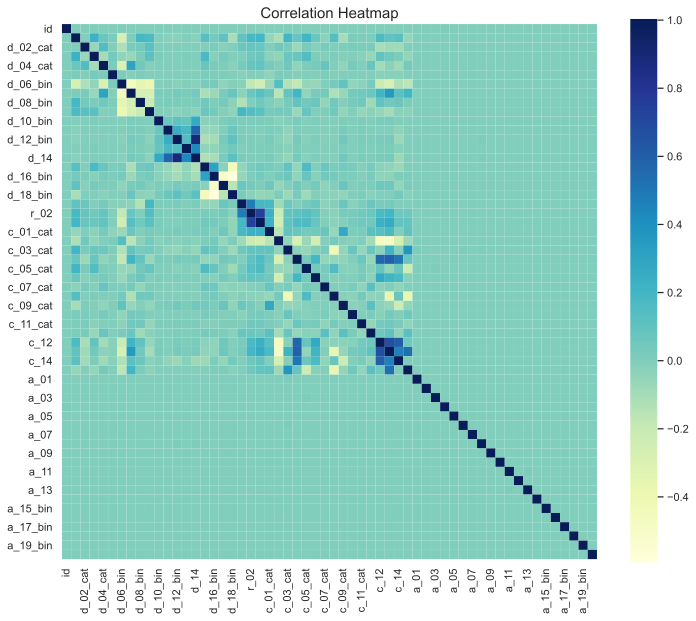

In [11]:
# Before making heatmap: We must replace -1 with nan.
# Otherwise, the -1 values will interfare with correlation
temp_df = train_df.copy(deep=True)
for col in temp_df.columns:
    temp_df[col].replace(-1, np.nan, inplace=True)
    
makeHeatmap(df=temp_df, cols = temp_df.columns, annot = False, line=False)

### Insight:
- All artificial features have zero correlation with others,
- We will delete these features.

In [12]:
# We delete feature with zero correlation with the rest:
del_col = cols = [col for col in train_df.columns if "a_" in col]

print('Before deleting, there are {:d} features in the dataset.'.format(train_df.shape[1]))
train_df.drop(columns = del_col, axis=1, inplace=True)
test_df.drop(columns = del_col, axis=1, inplace=True)

print('After deleting, there are {:d} features in the dataset.'.format(train_df.shape[1]))

Before deleting, there are 59 features in the dataset.
After deleting, there are 39 features in the dataset.


### Making a dataframe for metadata:

In [13]:
def make_metadata(df):
    data = []
    for feature in df.columns:
        # Defining the role
        if feature == 'target':
            role = 'target'
        elif feature == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the type
        if 'bin' in feature or feature == 'target':
            type = 'binary'
        elif 'cat' in feature or feature == 'id':
            type = 'categorical'
        elif (df[feature].dtype == 'float32') | (df[feature].dtype == 'float64'):
            type = 'numeric'
        else:
            type = 'ordinal'

        # Initialize preserve to True for all variables except for id
        preserve = True
        if feature == 'id':
            preserve = False

        # Defining the data type 
        dtype = df[feature].dtype

        category = 'none'
        # Defining the category
        if 'd_' in feature:
            category = 'driver'
        elif 'r_' in feature:
            category = 'region'
        elif 'c_' in feature:
            category = 'car'
        elif 'a_' in feature:
            category = 'artificial'

        uniqueCnt = df[feature].nunique()


        # Creating a dictionary for adding a row to metadata:
        feature_dictionary = {
            'varname': feature,
            'role': role,
            'type': type,
            'preserve': preserve,
            'dtype': dtype,
            'category' : category,
            'uniqueCnt': uniqueCnt
        }
        data.append(feature_dictionary)

    metadata = pd.DataFrame(data, columns=['varname', 'role', 'type', 'preserve', 'dtype', 'category', 'uniqueCnt'])
    metadata.set_index('varname', inplace=True)
    return metadata

In [14]:
metadata = make_metadata(train_df)
metadata.head()

role         type  preserve   dtype category  uniqueCnt
varname                                                            
id            id  categorical     False   int64     none     595212
target    target       binary      True  object     none          2
d_01       input      ordinal      True   int64   driver          8
d_02_cat   input  categorical      True   int64   driver          5
d_03       input      ordinal      True   int64   driver         12

### Question: 
- How many features belong to **different category**?

In [15]:
catFeatures, catCnt, cat_df = make_typedf(train_df, metadata, 'categorical')
ordFeatures, ordCnt, ord_df = make_typedf(train_df, metadata, 'ordinal')
numFeatures, numCnt, num_df = make_typedf(train_df, metadata, 'numeric')
binFeatures, binCnt, bin_df = make_typedf(train_df, metadata, 'binary')

In [16]:
cat_df.head(3)

feature uniqueCnt
0  d_02_cat         5
1  d_04_cat         3
2  d_05_cat         8

#### Question: Do we have features with only one unique input?
- If yes, of course they cannot help prediction.

In [17]:
identify_single_unique(train_df)

There are 0 features with a single unique value.


[]

### Question:
- Do we have features that their values are are dominant only by one value?
- If yes, they are likely to have less impact on the prediction process.
- If yes, how is the crosstabel with target variable?

In [18]:
cols = catFeatures + ordFeatures + binFeatures
frequency_df = levelFrequency(train_df, cols)
frequency_df.head(10)

feature  frequency
0  d_10_bin      99.96
1  d_13_bin      99.91
2  d_11_bin      99.83
3  c_10_cat      99.15
4  d_12_bin      99.06
5      d_14      98.93
6    target      96.36
7  c_07_cat      92.93
8  d_05_cat      88.71
9  d_17_bin      87.89

### Insight:
- We have 5 variables that more than 99% of the records have same value in these features.
- They can have less impact on prediction. 
- But the crosstab shows that when these features take none dominant values there are more chance for claim, so we will keep them. 

In [19]:
pd.crosstab(train_df['d_10_bin'], train_df['target'])#, normalize='index')

target    Claim  No_Claim
d_10_bin                 
0         21682    573308
1            12       210

In [20]:
pd.crosstab(train_df['d_10_bin'], train_df['target'], normalize='index')

target       Claim  No_Claim
d_10_bin                    
0         0.036441  0.963559
1         0.054054  0.945946

In [21]:
pd.crosstab(train_df['d_13_bin'], train_df['target'], normalize='index')

target       Claim  No_Claim
d_13_bin                    
0         0.036433  0.963567
1         0.051418  0.948582

In [22]:
pd.crosstab(train_df['d_11_bin'], train_df['target'], normalize='index')

target       Claim  No_Claim
d_11_bin                    
0         0.036432  0.963568
1         0.045680  0.954320

### Question:
- What is the distribution of missing values?
- According to the dataset describtion, indicator for missing records is the value of "-1"

In [23]:
missCnt = checkMissValue(train_df, metadata)
missCntTest = checkMissValue(test_df, metadata)

In [24]:
missCnt.head(5)

count percentage         type
c_03_cat  411231    69.0898  categorical
c_05_cat  266551    44.7825  categorical
r_03      107772    18.1065      numeric
c_14       42620    7.16047      numeric
c_07_cat   11489    1.93024  categorical

In [25]:
missCntTest.head(5)

count percentage         type
c_03_cat  616911    69.0972  categorical
c_05_cat  400359    44.8423  categorical
r_03      161684    18.1094      numeric
c_14       63805    7.14649      numeric
c_07_cat   17331    1.94116  categorical

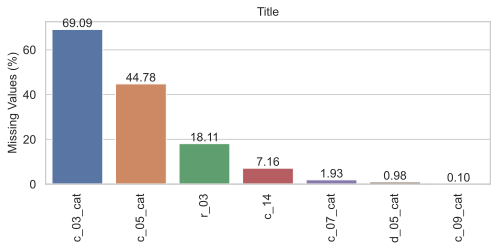

In [26]:
make_bar_plot(X=missCnt.index[:7], y=missCnt['percentage'][:7], y_label='Missing Values (%)', x_Rotation = 90, width=8, height=3, sort=True, annot= True);
plt.savefig(imageDirectory + '\\missing_values.png', dpi=140,  bbox_inches='tight')

#### Insight:
- The two features ps_car_03_cat and ps_car_05_cat have many missing values, We can get rid of them.
- We keep the rest of features without modification, if they are categorical.
- If not categorical, we have to impute them.

In [27]:
# We delete the two features with the most level of missing.
del_col = list(missCnt[:2].index)
del_col

print('For train data set:')
print('Before deleting, there are {:d} features in the dataset.'.format(train_df.shape[1]))
train_df.drop(columns = del_col, axis=1, inplace=True)
print('After deleting, there are {:d} features in the dataset.'.format(train_df.shape[1]))


print('\nFor test data set:')
print('Before deleting, there are {:d} features in the dataset.'.format(test_df.shape[1]))
test_df.drop(columns = del_col, axis=1, inplace=True)
print('After deleting, there are {:d} features in the dataset.'.format(test_df.shape[1]))

For train data set:
Before deleting, there are 39 features in the dataset.
After deleting, there are 37 features in the dataset.

For test data set:
Before deleting, there are 38 features in the dataset.
After deleting, there are 36 features in the dataset.


### Feature Engineering as an indicator for missing value

In [28]:
train_df['has_missing'] = ((train_df == -1).sum(axis=1)>0).astype(int)
test_df['has_missing'] = ((test_df == -1).sum(axis=1)>0).astype(int)

In [29]:
# Since we add a new feature, we will update metadata
metadata = make_metadata(train_df)

catFeatures, catCnt, cat_df = make_typedf(train_df, metadata, 'categorical')
ordFeatures, ordCnt, ord_df = make_typedf(train_df, metadata, 'ordinal')
numFeatures, numCnt, num_df = make_typedf(train_df, metadata, 'numeric')
binFeatures, binCnt, bin_df = make_typedf(train_df, metadata, 'binary')

### Treating of missing values:
- We will keep missing values of categorical features.
- We will impute missing values of numerical features.

In [30]:
missCnt[(missCnt['percentage']!= 0) & (missCnt['type']!= 'categorical')]

count   percentage     type
r_03  107772      18.1065  numeric
c_14   42620      7.16047  numeric
c_11       5  0.000840037  ordinal
c_12       1  0.000168007  numeric

In [31]:
missCntTest[(missCntTest['percentage']!= 0) & (missCntTest['type']!= 'categorical')]

count   percentage     type
r_03  161684      18.1094  numeric
c_14   63805      7.14649  numeric
c_11       1  0.000112005  ordinal

#### Explanation:
- We have two set of features with missing data:
    - features with few missing data.
    - features with more than few missing data.

- There are two features which have very few missing values: 
   - **c_11** -->     5 rows have missed data. 
   - **c_12** -->     1 row has missed data. 
- For the features with a few missing values, imputing will ve done by statistics variables.
   - If categorical, they will be imputed by mode.
   - For ordinal, they can be imputed by average or median.
   - Average will be impacted by outliers, but median is robust to outliers.

### Numerical variables:
- First we take a look at the data to check whether we have outlier ot not?
- **c_11 and c_12**.

### Median or Mean?
For the data with outliers, it is recommended to impute by median to supress impact of outliers.

In [32]:
make_box_plot(df=train_df, cols=['c_11', 'c_12'])

#### Insight:
- It is likely that we have outliers in case of c_12. 
- It is prefered that median be used for imputing the missing values.

In [33]:
train_df['c_11'].replace(-1, train_df['c_11'].median(), inplace=True)
train_df['c_12'].replace(-1, train_df['c_12'].median(), inplace=True)

test_df['c_11'].replace(-1, test_df['c_11'].median(), inplace=True)

### Imputing of two features:
- 'r_03'
- 'c_14'

In [34]:
# replacing -1 values with nan values:
cols = ['r_03', 'c_14']
print('Before replacing, count of missing values is:')
print(np.array(train_df.isnull().sum()).sum())
for col in cols:
    train_df[col].replace(-1, np.nan, inplace=True)
    test_df[col].replace(-1, np.nan, inplace=True)
print('After replacing, count of missing values is:')
print(np.array(train_df.isnull().sum()).sum())

Before replacing, count of missing values is:
0
After replacing, count of missing values is:
150392


In [35]:
# For train_df
corr_matrix = make_correlated_table(train_df, ['r_03', 'c_14'])
corr_matrix

Elapsed time:  0.000 seconds


miss_feat corr_feat1  corr_val1  miss_count1  weight_1 corr_feat2  \
0      r_03       r_02   0.742668            0  0.742668       c_13   
1      c_14       c_12   0.603358            0  0.603358   c_04_cat   

   corr_val2  miss_count2  weight_2  
0   0.264800            0  0.264800  
1   0.512817            0  0.512817

In [36]:
# For test_df
corr_matrixTest = make_correlated_table(test_df, ['r_03', 'c_14'])
corr_matrixTest

Elapsed time:  0.016 seconds


miss_feat corr_feat1  corr_val1  miss_count1  weight_1 corr_feat2  \
0      r_03       r_02   0.742668            0  0.742668       c_13   
1      c_14       c_12   0.602274            0  0.602274   c_04_cat   

   corr_val2  miss_count2  weight_2  
0   0.264066            0  0.264066  
1   0.513472            0  0.513472

#### Imputing missing values using regression model:

In [37]:
train_df = imputby_Regression(data_df=train_df, corr_df=corr_matrix, useOneCorrFeature= False)
test_df = imputby_Regression(data_df=test_df, corr_df=corr_matrixTest, useOneCorrFeature= False)

After imputing, Rows with missed data: 0
After imputing, Rows with missed data: 0
After imputing, Rows with missed data: 0
After imputing, Rows with missed data: 0


In [38]:
def corrComparison(df, corr_df, col):
    corr = df.corr()[col]
    corr = abs(corr).sort_values(ascending = False)
    corr = corr[1:3]
    corr=pd.DataFrame(corr)

    val1 = corr_df.loc[corr_df['miss_feat']==col,'corr_val1'].values
    val2 = corr_df.loc[corr_df['miss_feat']==col,'corr_val2'].values
    val3 = np.concatenate((val1, val2))
    
    corr['oldCorrelation']= val3
    corr.rename(columns={col:'newCorrelation'}, inplace=True)
    
    fig, ax = plt.subplots(figsize=(5,3.5))
    corr.plot(kind='bar', ax = ax);
    ax.set_title('Impact of imputation on corrlation of feature: {}'.format(col))
    ax.set_xlabel('Correlated Features', size = 10)
    ax.set_ylabel('Correlation value', size = 10);
    plt.xticks(rotation=90);

    ax.legend(bbox_to_anchor=(1.55,0.25), loc='upper right', borderaxespad=0)
    return corr

### Impact of imputing on correlation

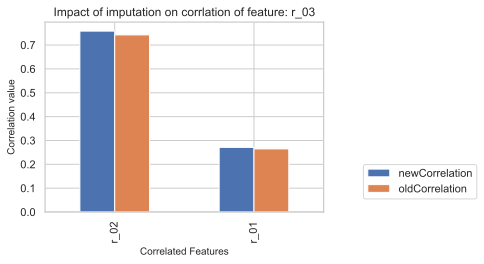

In [39]:
res = corrComparison(df=train_df, corr_df=corr_matrix , col='r_03')

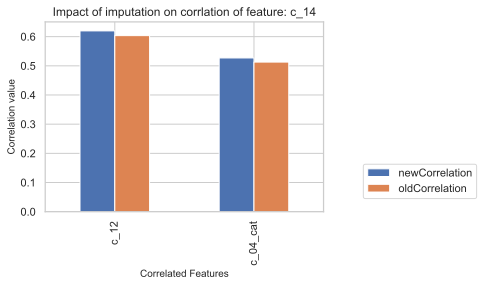

In [40]:
res = corrComparison(df=train_df, corr_df=corr_matrix , col='c_14')

#### Summary of missing values treatment:
- Missing values of **numerical features** are imputed using regression model.
- We keep the missing values in **Categorical features.** 
- In summary, we can see the comparison:

In [41]:
missCntNew = checkMissValue(train_df, metadata)
missCntTestNew = checkMissValue(test_df, metadata)

**Before Treatment:**

In [42]:
missCnt.head(10)

count percentage         type
c_03_cat  411231    69.0898  categorical
c_05_cat  266551    44.7825  categorical
r_03      107772    18.1065      numeric
c_14       42620    7.16047      numeric
c_07_cat   11489    1.93024  categorical
d_05_cat    5809   0.975955  categorical
c_09_cat     569  0.0955962  categorical
d_02_cat     216  0.0362896  categorical
c_01_cat     107  0.0179768  categorical
d_04_cat      83  0.0139446  categorical

**After Treatment:**

In [43]:
missCntNew.head(10)

count   percentage         type
c_07_cat  11489      1.93024  categorical
d_05_cat   5809     0.975955  categorical
c_09_cat    569    0.0955962  categorical
d_02_cat    216    0.0362896  categorical
c_01_cat    107    0.0179768  categorical
d_04_cat     83    0.0139446  categorical
c_02_cat      5  0.000840037  categorical
id            0            0  categorical
c_04_cat      0            0  categorical
c_06_cat      0            0  categorical

**Also for test dataset:**

In [44]:
missCntTest[:10]

count percentage         type
c_03_cat  616911    69.0972  categorical
c_05_cat  400359    44.8423  categorical
r_03      161684    18.1094      numeric
c_14       63805    7.14649      numeric
c_07_cat   17331    1.94116  categorical
d_05_cat    8710   0.975565  categorical
c_09_cat     877  0.0982285  categorical
d_02_cat     307  0.0343856  categorical
c_01_cat     160  0.0179208  categorical
d_04_cat     145  0.0162407  categorical

In [45]:
missCntTestNew[:10]

count   percentage         type
c_07_cat  17331      1.94116  categorical
d_05_cat   8710     0.975565  categorical
c_09_cat    877    0.0982285  categorical
d_02_cat    307    0.0343856  categorical
c_01_cat    160    0.0179208  categorical
d_04_cat    145    0.0162407  categorical
c_02_cat      5  0.000560026  categorical
id            0            0  categorical
c_04_cat      0            0  categorical
c_06_cat      0            0  categorical

### Summary:
- In case of numerical features, we imputed the missing values,
- However, we do not treat missing value in the categorical features. In fact, it is prefered to keep them as a new category rather than being imputed.

### Exporting dataset for future using:

In [46]:
train_df.to_csv(dataDirectory + "\\train_car_insurance_Tohid.csv", index=False)
test_df.to_csv(dataDirectory + "\\test_car_insurance_Tohid.csv", index=False)